In [24]:
!pip install keras

In [25]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

--2018-06-04 04:45:05--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip.1’

horse2zebra.zip.1   100%[===================>] 111.45M  20.1MB/s    in 6.6s    

2018-06-04 04:45:12 (16.9 MB/s) - ‘horse2zebra.zip.1’ saved [116867962/116867962]



In [26]:
!unzip horse2zebra.zip -d .

Archive:  horse2zebra.zip
replace ./horse2zebra/trainA/n02381460_6223.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
!mkdir out_imgs

mkdir: cannot create directory ‘out_imgs’: File exists


In [2]:
import time
import os
import keras.backend as K
K.set_image_data_format('channels_last')
channel_axis=-1
channel_first = False


from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal



Using TensorFlow backend.


In [0]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization

In [0]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, None, None))
    else:
        input_a = Input(shape=(None, None, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid" if use_sigmoid else None) (_)    
    return Model(inputs=[input_a], outputs=_)

In [0]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [0]:


nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
λ = 10 if use_lsgan else 100

loadSize = 143
imageSize = 128
batchSize = 1
lrD = 2e-4
lrG = 2e-4



In [7]:
netDA = BASIC_D(nc_in, ndf, use_sigmoid = not use_lsgan)
netDB = BASIC_D(nc_out, ndf, use_sigmoid = not use_lsgan)
netDA.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
First (Conv2D)               (None, None, None, 64)    3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, None, None, 128)   131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 128)   512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 128)   0         
_________________________________________________________________
pyramid.2 (Conv2D)           (None, None, None, 256)   524288    
__________

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


netGB = UNET_G(imageSize, nc_in, nc_out, ngf)
netGA = UNET_G(imageSize, nc_out, nc_in, ngf)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
netGA.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv_128 (Conv2D)               (None, 64, 64, 64)   3136        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 64, 64, 64)   0           conv_128[0][0]                   
__________________________________________________________________________________________________
conv_64 (Conv2D)                (None, 32, 32, 128)  131072      leaky_re_lu_15[0][0]             
__________________________________________________________________________________________________
batch_norm

In [9]:
from keras.models import load_model
netGA = load_model('netGA.h5')
netGB = load_model('netGB.h5')

/usr/local/lib/python3.6/dist-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
from keras.optimizers import RMSprop, SGD, Adam

In [0]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(netGB, netGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(netGA, netGB)

In [0]:
def D_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cycB = D_loss(netDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA+loss_cycB

In [0]:
loss_G = loss_GA+loss_GB+λ*loss_cyc
loss_D = loss_DA+loss_DB

weightsD = netDA.trainable_weights + netDB.trainable_weights
weightsG = netGA.trainable_weights + netGB.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_DA/2, loss_DB/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], training_updates)

In [0]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img

#data = "edges2shoes"
data = "horse2zebra"
train_A = load_data('./{}/trainA/*.jpg'.format(data))
train_B = load_data('./{}/trainB/*.jpg'.format(data))

assert len(train_A) and len(train_B)

In [0]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch(dataA, batchsize)
    batchB=minibatch(dataB, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

In [0]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))
    Image.fromarray(int_X).save('./out_imgs/'+str(int(time.time()))+'.jpg')

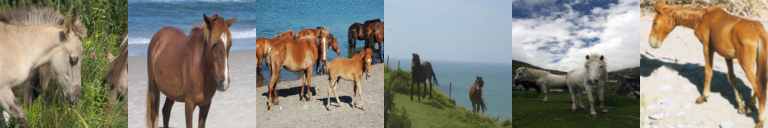

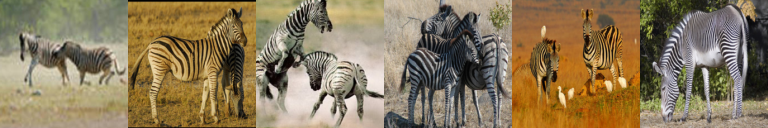

In [17]:
train_batch = minibatchAB(train_A, train_B, 6)

_, A, B = next(train_batch)
showX(A)
showX(B)
del train_batch, A, B

In [0]:
def showG(A,B):
    assert A.shape==B.shape
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    showX(arr, 3)

[19/20][19750] Loss_D: 0.242738 0.170070 Loss_G: 0.451194 0.628922 loss_cyc 0.107699 9543.450950622559


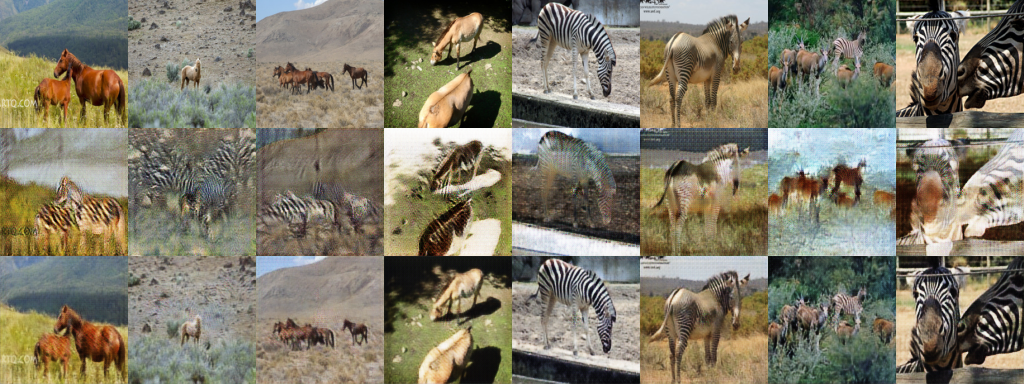

In [17]:

from IPython.display import clear_output
t0 = time.time()
niter = 20
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

display_iters = 50
#val_batch = minibatch(valAB, 6, direction)
lost_GA=[]
lost_GB=[]
lost_DA=[]
lost_DB=[]
train_batch = minibatchAB(train_A, train_B, batchSize)

while epoch < niter: 
    epoch, A, B = next(train_batch)        
    errDA, errDB  = netD_train([A, B])
    errDA_sum +=errDA
    errDB_sum +=errDB
    lost_DA.append(errDA)
    lost_DB.append(errDB)
    
    # epoch, trainA, trainB = next(train_batch)
    errGA, errGB, errCyc = netG_train([A, B])
    lost_GA.append(errGA)
    lost_GB.append(errGA)
    errGA_sum += errGA
    errGB_sum += errGB
    errCyc_sum += errCyc
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        #if gen_iterations%(5*display_iters)==0:
        clear_output()
        print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
        % (epoch, niter, gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, 
           errCyc_sum/display_iters), time.time()-t0)
        _, A, B = train_batch.send(4)
        showG(A,B)        
        errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

In [18]:
len(lost_GA[1000:])

18761

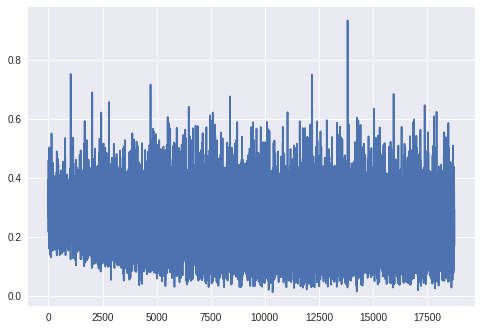

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(18761), lost_DA[1000:])

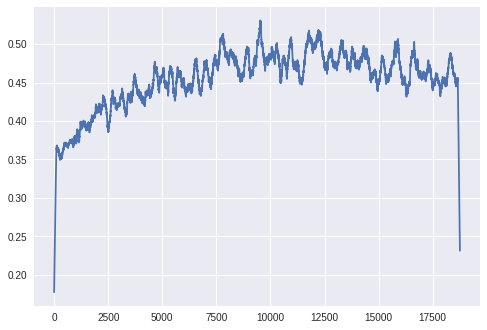

In [20]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(range(18761), smooth(lost_GA[1000:],200))

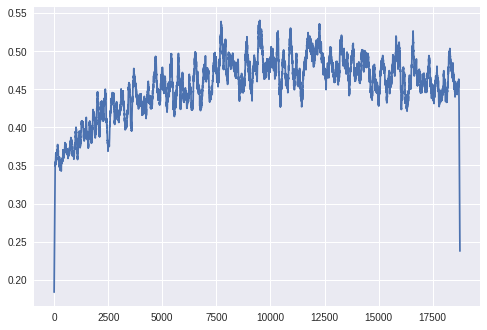

In [21]:
plt.plot(range(18761), smooth(lost_GB[1000:],100))

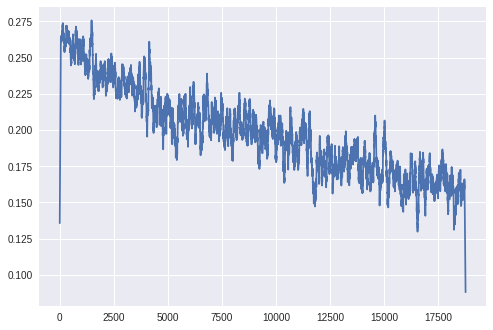

In [22]:
plt.plot(range(18761), smooth(lost_DB[1000:],100))

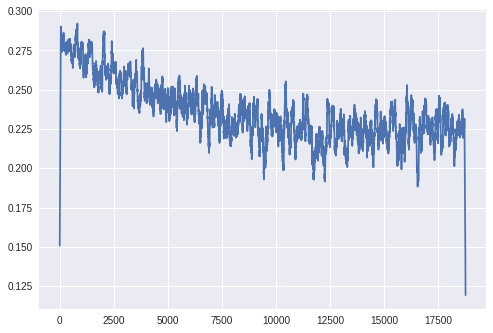

In [23]:
plt.plot(range(18761), smooth(lost_DA[1000:],100))

In [24]:
!ls out_imgs/

1528090640.jpg	1528103659.jpg	1528107554.jpg	1528113091.jpg	1528117001.jpg
1528090677.jpg	1528103683.jpg	1528107578.jpg	1528113116.jpg	1528117025.jpg
1528090701.jpg	1528103707.jpg	1528107602.jpg	1528113140.jpg	1528117049.jpg
1528090726.jpg	1528103731.jpg	1528107626.jpg	1528113164.jpg	1528117073.jpg
1528090750.jpg	1528103755.jpg	1528107650.jpg	1528113188.jpg	1528117097.jpg
1528090774.jpg	1528103779.jpg	1528107674.jpg	1528113212.jpg	1528117121.jpg
1528090798.jpg	1528103803.jpg	1528107698.jpg	1528113236.jpg	1528117146.jpg
1528090822.jpg	1528103827.jpg	1528107722.jpg	1528113261.jpg	1528117170.jpg
1528090846.jpg	1528103851.jpg	1528107746.jpg	1528113285.jpg	1528117194.jpg
1528090870.jpg	1528103875.jpg	1528107770.jpg	1528113309.jpg	1528117218.jpg
1528090894.jpg	1528103899.jpg	1528107794.jpg	1528113333.jpg	1528117242.jpg
1528090918.jpg	1528103924.jpg	1528107818.jpg	1528113357.jpg	1528117266.jpg
1528090942.jpg	1528103948.jpg	1528107842.jpg	1528113381.jpg	1528117290.jpg
1528090966.jpg	1528103972

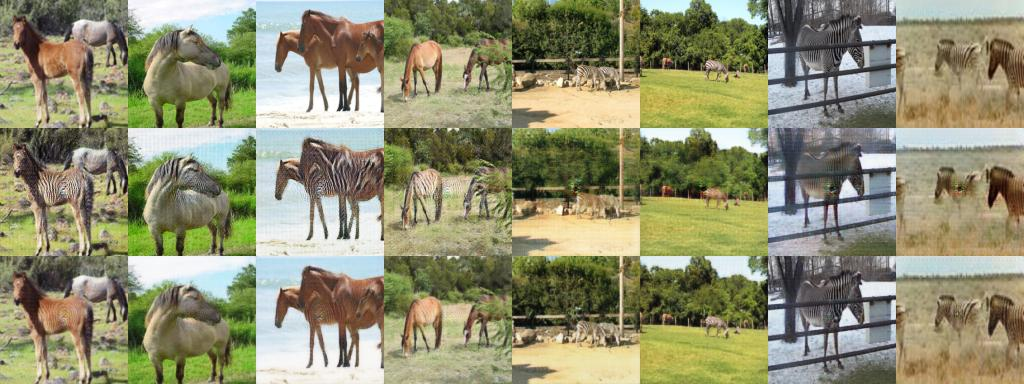

In [25]:
from IPython.display import Image as dis_imgs
dis_imgs('./out_imgs/1528107578.jpg')

In [0]:
netGB.save('netGB.h5') 

In [0]:
netGA.save('netGA.h5') 

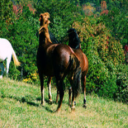

In [19]:
rtn = np.float32([read_image('horse2zebra/testA/n02381460_1000.jpg')])
showX(rtn)

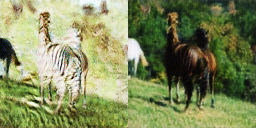

In [20]:
def G(fn_generate, X):
    r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
    return r.swapaxes(0,1)[:,:,0]        
rA = G(cycleA_generate, rtn)
showX(rA)

In [0]:
del netGA
del netGB

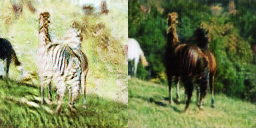

In [21]:
def G(fn_generate, X):
    r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
    return r.swapaxes(0,1)[:,:,0]        
rA = G(cycleA_generate, rtn)
showX(rA)

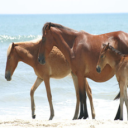

In [22]:
rtn = np.float32([read_image('horse2zebra/testA/n02381460_120.jpg')])
showX(rtn)
# !ls horse2zebra/testA

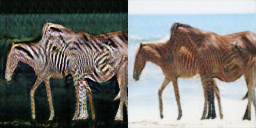

In [23]:
def G(fn_generate, X):
    r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
    return r.swapaxes(0,1)[:,:,0]        
rA = G(cycleA_generate, rtn)
showX(rA)